# подготовка

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import logging

import polars as pl
import datetime

import requests
import zipfile

import time
import collections
import pandas as pd
import numpy as np

import torch

import numpy as np
import pandas as pd
import torch
import collections
import time
import hashlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import mannwhitneyu, ttest_ind, norm

import warnings
warnings.filterwarnings('ignore')

In [4]:
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

kion dataset download: 100%|██████████| 78.8M/78.8M [02:49<00:00, 464kiB/s] 


In [5]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

In [6]:
interactions.head(5)

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [21]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()

# выделим данные за одну (последнюю) неделю
week = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]
week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})

# выделим данные за последние 2 недели
two_week = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
two_week = two_week.groupby('user_id', as_index=False).agg({'total_dur': sum})

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


/var/folders/t3/409cw_p51s3_b296bytqrv3x8ch15l/T/ipykernel_29434/2769211251.py:13: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})
/var/folders/t3/409cw_p51s3_b296bytqrv3x8ch15l/T/ipykernel_29434/2769211251.py:17: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  two_week = two_week.groupby('user_id', as_index=False).agg({'total_dur': sum})


In [22]:
# уберем выбросы 3std
two_week = two_week[(two_week['total_dur'] < two_week['total_dur'].std() * 3)]
week = week[(week['total_dur'] < week['total_dur'].std() * 3)]

# дизайн теста бутстреп

In [ ]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    # генерируем случайный "соль" - строку для хэширования, чтобы при разных итерациях 
    # пользователи по-разному распределялись между группами
    # 8 рандомных байт превращаем в строку
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df, columns, user_salt=None):
    '''
    Функция делит пользователей на 2 группы (A и B) исходя из user_id + соль.
    '''
    if user_salt is None:
        salt = salt_generator()
    else:
        salt = user_salt

    # создаём хеш на основе user_id и соли.
    df['hash'] = (df['user_id'].astype(str) + '#' + salt).apply(
        lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest()
    )

    # берём последние 6 символов хеша, переводим в число int с base=16 (шестнадцатеричное)
    # далее берем остаток от деления на 2, если 0 - группа A, если 1 - группа B.
    df['group'] = (df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(
        lambda x: 'A' if x == 0 else 'B'
    )

    # возвращаем только нужные столбцы и убираем дубликаты, чтобы не было повторений
    return df[columns].drop_duplicates()


def bootstrap_means_torch(vec, size=1000):
    '''
    Бутстрепим данные с помощью PyTorch (ускорение)
    '''
    n = vec.shape[0]
    # генерируем индексы для бутстрепа: для каждой из size итераций берём n сэмплов с возвращением
    bootstrap_indices = torch.randint(0, n, (size, n), device=vec.device)
    # собираем выборки по индексам и возвращаем среднее по каждой бутстреп-выборке
    sampled = vec[bootstrap_indices]
    return sampled.mean(dim=1)


def get_p_value(dist):
    # p-value через перестановочный бутстреп: доля случаев, когда разница > 0 (или <0), умноженная на 2
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

## валидируем корректноcть

In [ ]:
def process_single_iteration(week, salt_generator, groups_splitter, bias=0.0):
    """
    Одна итерация теста корректности с использованием GPU
    """
    # Применяем groups_splitter - это узкое место, оптимизация возможна если внутри него есть большие затраты
    new_df = groups_splitter(
        week,
        columns=['user_id', 'total_dur', 'group'],
        user_salt=salt_generator()
    ).drop_duplicates()
    
    if bias != 0.0:
        new_df.loc[new_df['group'] == 'B', 'total_dur'] = (
            new_df.loc[new_df['group'] == 'B', 'total_dur'] * (1.0 + bias)
        ).astype(new_df['total_dur'].dtype)

    mask_a = (new_df['group'].values == 'A')
    mask_b = (new_df['group'].values == 'B')
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    vec_a = torch.tensor(new_df['total_dur'].values[mask_a].astype(np.float32), device=device)
    vec_b = torch.tensor(new_df['total_dur'].values[mask_b].astype(np.float32), device=device)

    # бутстрап средних на GPU
    sample_a_mean = bootstrap_means_torch(vec_a, size=1000)
    sample_b_mean = bootstrap_means_torch(vec_b, size=1000)

    diff_means = sample_a_mean - sample_b_mean

    # используем sort и индексирование для получения 2.5 и 97.5 перцентилей (=95й доверительный интервал)
    sorted_diff = torch.sort(diff_means).values
    left_side = sorted_diff[int(0.025 * 1000)]
    right_side = sorted_diff[int(0.975 * 1000)]

    return diff_means, not (left_side <= 0 <= right_side)


def run_correction(df: pd.DataFrame, df_name: str, size: int=50):
    start_time = time.time()
    values = []
    correctness = []
    for _ in tqdm(range(size), desc="Processing iterations"):
        diff_means, res = process_single_iteration(df, salt_generator, groups_splitter)
        correctness.append(res)
        values.append(diff_means)

    test_correctness = collections.Counter(correctness)
    significance = test_correctness[True] / (test_correctness[True] + test_correctness[False]) * 100

    end_time = time.time()
    print(f'significance {df_name}: {significance}%')
    print(f'время выполнения {df_name}: {end_time - start_time:.2f} секунд')
    return values, correctness

In [38]:
values_week_s, correctness_week_s = run_correction(week, 'one_week_50iters', size=50)
values_week, correctness_week = run_correction(week, 'one_week_1000iters', size=1000)
values_two_week, correctness_two_week = run_correction(two_week, 'two_week_1000iters', size=1000)

Processing iterations: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


significance one_week_50iters: 2.0%
Время выполнения one_week_50iters: 53.38 секунд


Processing iterations: 100%|██████████| 1000/1000 [17:14<00:00,  1.03s/it]


significance one_week_1000iters: 4.8%
Время выполнения one_week_1000iters: 1034.39 секунд


Processing iterations: 100%|██████████| 1000/1000 [26:14<00:00,  1.57s/it]

significance two_week_1000iters: 5.1%
Время выполнения two_week_1000iters: 1575.00 секунд


объяснение:
- на 50 итерациях одной недели 2% - это очень хороший процент ошибки, т.е. всего один из 50 тестов провалился
- при увеличении до 1000 процент подрастает, 48 тестов провалились, но это все еще ок
- при увеличении данных до 2х недель корректность (альфа) составила около 5%, что вполне уместно; слабое изменение в сравнении с промежутком в неделю говорит о том, что данные достаточно однородные и с ними можно работать

видим, что процент ошибок увеличивается с ростом итераций, но это может быть и погрешностью; все равно довольно маленький и приемлемый процент, как раз то, что и хочется получить от альфы (0.05)

In [39]:
p_values_week_s = [get_p_value(dist) for dist in values_week_s]
p_values_week = [get_p_value(dist) for dist in values_week]
p_values_two_week = [get_p_value(dist) for dist in values_two_week]

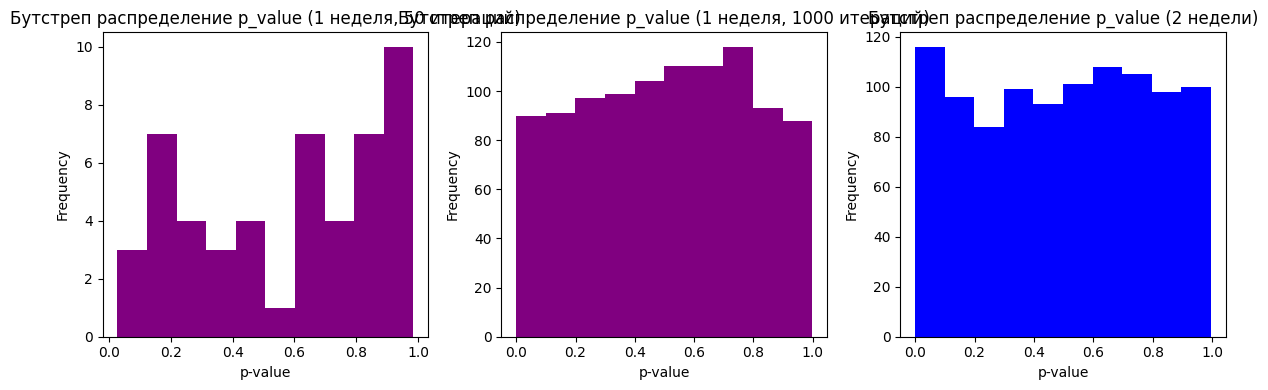

In [40]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(p_values_week_s, bins=10, color='purple')
axes[0].set_title("Бутстреп распределение p_value (1 неделя, 50 итераций)")
axes[0].set_xlabel("p-value")
axes[0].set_ylabel("Frequency")

axes[1].hist(p_values_week, bins=10, color='purple')
axes[1].set_title("Бутстреп распределение p_value (1 неделя, 1000 итераций)")
axes[1].set_xlabel("p-value")
axes[1].set_ylabel("Frequency")

axes[2].hist(p_values_two_week, bins=10, color='blue')
axes[2].set_title("Бутстреп распределение p_value (2 недели)")
axes[2].set_xlabel("p-value")
axes[2].set_ylabel("Frequency")
plt.tight_layout()

по графикам все +- норм для 1000 итераций, слишком сильных выбросов нигде не видно; на 50 итерациях график шатает очень сильно, сложно какой-то вывод делать (только о том, что надо больше итераций)

двухнедельный график более равномерный, потому что охватывает сразу два недельных цикла

## валидируем мощность

In [71]:
def run_correction(df: pd.DataFrame, df_name: str, size: int=1000, bias: float=0.0):
    start_time = time.time()
    power = []
    with tqdm(range(size), desc="Processing iterations", dynamic_ncols=True, leave=True) as pbar:
        for _ in pbar:
            diff_means, power_i = process_single_iteration(df, salt_generator, groups_splitter, bias=bias)
            power.append(power_i)

    test_power = collections.Counter(power)
    end_time = time.time()
    print(f'power {df_name}: {test_power[1]/(test_power[1] + test_power[0])*100}%')
    print(f'Время выполнения {df_name}: {end_time - start_time:.2f} секунд')
    return power

power_01 = run_correction(two_week, 'two_week_01', 1000, 0.01)
power_03 = run_correction(two_week, 'two_week_03', 1000, 0.03)
power_05 = run_correction(two_week, 'two_week_05', 1000, 0.05)

Processing iterations: 100%|██████████| 1000/1000 [27:47<00:00,  1.67s/it]


power two_week_01: 31.2%
Время выполнения two_week_01: 1667.93 секунд


Processing iterations: 100%|██████████| 1000/1000 [27:16<00:00,  1.64s/it]


power two_week_03: 99.0%
Время выполнения two_week_03: 1636.80 секунд


Processing iterations: 100%|██████████| 1000/1000 [26:42<00:00,  1.60s/it]

power two_week_05: 100.0%
Время выполнения two_week_05: 1602.60 секунд


Логических ошибок нет - чем больше добавляемый эффект, тем больше мощность (те чем больше реальная разница, которую я пытаюсь уловить, тем выше вероятность, что статистические методы посчитают эту разницу значимой)

5% - слишком много, как оказывается; мощность получается 100% - т.е. всегда обнаруживается эффект) 

In [ ]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    print(f'MDE: {mde:.2f}')
    return mde*100/metric_mean

corr_two_week_counter = collections.Counter(correctness_two_week)
alpha = corr_two_week_counter[True] / (corr_two_week_counter[True] + corr_two_week_counter[False])

# beta = 1 - power
power_two_week_counter = collections.Counter(power_05)
beta05 = 1 - (power_two_week_counter[True] / (power_two_week_counter[True] + power_two_week_counter[False]))
power_two_week_counter = collections.Counter(power_03)
beta03 = 1 - (power_two_week_counter[True] / (power_two_week_counter[True] + power_two_week_counter[False]))
power_two_week_counter = collections.Counter(power_01)
beta01 = 1 - (power_two_week_counter[True] / (power_two_week_counter[True] + power_two_week_counter[False]))

# почитаем MDE
mde01 = get_mde(two_week['total_dur'], alpha=alpha, beta=beta01)
mde03 = get_mde(two_week['total_dur'], alpha=alpha, beta=beta03)
mde05 = get_mde(two_week['total_dur'], alpha=alpha, beta=beta05)


MDE: 78.88
MDE: 230.93
MDE: inf


In [80]:
two_week['total_dur'].mean()

np.float64(16222.438029722513)

In [ ]:
# MDE вполне вменяемое по масштабам  и понятное: чем БОЛЬШЕ мощность тем МЕНЬШЕ MDE;
# чем больше мощность => тем более чувствителен тест к изменениям => тем меньшие изменения нужны для фиксации результата

# Дизайн продолжение

In [ ]:
def test_bootstrap(vec_a, vec_b, alpha=0.05, size=1000):
    '''
    Бутстрепный тест: генерируем бутстрепные распределения для A и B, смотрим разницу средних,
    формируем доверительный интервал и проверяем, пересекает ли он 0.
    '''
    sample_a_mean = bootstrap_means_torch(vec_a, size=size)
    sample_b_mean = bootstrap_means_torch(vec_b, size=size)
    diff_means = sample_a_mean - sample_b_mean
    # сортируем, чтобы взять квантили
    sorted_diff = torch.sort(diff_means).values
    left_side = sorted_diff[int(0.025 * size)]
    right_side = sorted_diff[int(0.975 * size)]

    # если интервал не включает 0 - значит статистически значимо
    res = not (left_side <= 0 <= right_side)

    # p-value бутстрэпа
    diff_array = diff_means.cpu().numpy()
    p = get_p_value(diff_array)
    return diff_array, p, res


def test_mannwhitney(vec_a, vec_b, alpha=0.05):
    '''
    тест Манна-Уитни
    '''
    a_cpu = vec_a.cpu().numpy()
    b_cpu = vec_b.cpu().numpy()
    stat, p = mannwhitneyu(a_cpu, b_cpu, alternative='two-sided')
    diff_means = a_cpu.mean() - b_cpu.mean()
    res = (p < alpha) # если p-value меньше уровня значимости - отвергаем нулевую гипотезу
    return np.array([diff_means]), p, res


def test_ttest(vec_a, vec_b, alpha=0.05):
    '''
    t-тест Стьюдента
    '''
    a_cpu = vec_a.cpu().numpy()
    b_cpu = vec_b.cpu().numpy()
    stat, p = ttest_ind(a_cpu, b_cpu, equal_var=False)
    diff_means = a_cpu.mean() - b_cpu.mean()
    res = (p < alpha) # аналогично, как в test_mannwhitneyu
    return np.array([diff_means]), p, res


def process_single_iteration(
    df, 
    salt_generator, 
    groups_splitter, 
    bias=0.0, 
    test_type='bootstrap', 
    transform='original'
):
    '''
    Одна итерация эксперимента:
    1. рандомно делим пользователей на группы (через groups_splitter);
    2. прибавляем эффект к группе B, если bias != 0;
    3. применяем трансформацию метрики (логарифмирование) если transform='log';
    4. применяем статистический тест (бутстреп/Манна-Уитни/t-тест).
    '''
    new_df = groups_splitter(
        df.copy(),
        columns=['user_id', 'total_dur', 'group'],
        user_salt=salt_generator()
    ).drop_duplicates()

    # добавляем эффект в группу B - это искусственное внесение разницы в данные
    if bias != 0.0:
        new_df.loc[new_df['group'] == 'B', 'total_dur'] = (
            new_df.loc[new_df['group'] == 'B', 'total_dur'] * (1.0 + bias)
        ).astype(new_df['total_dur'].dtype)

    # применяем трансформацию метрики. Если transform='log', то логарифмируем, иначе без изменений
    if transform == 'log':
        new_df['metric'] = np.log2(new_df['total_dur'])
    else:
        new_df['metric'] = new_df['total_dur']

    # создаем маски для групп
    mask_a = (new_df['group'].values == 'A')
    mask_b = (new_df['group'].values == 'B')

    # используем GPU если доступна
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    vec_a = torch.tensor(new_df['metric'].values[mask_a].astype(np.float32), device=device)
    vec_b = torch.tensor(new_df['metric'].values[mask_b].astype(np.float32), device=device)

    # вызываем выбранный тест
    if test_type == 'bootstrap':
        diff_means, p, res = test_bootstrap(vec_a, vec_b)
    elif test_type == 'mannwhitney':
        diff_means, p, res = test_mannwhitney(vec_a, vec_b)
    elif test_type == 'ttest':
        diff_means, p, res = test_ttest(vec_a, vec_b)
    else:
        raise ValueError("Unknown test_type")

    return diff_means, p, res


def run_experiment(
    df: pd.DataFrame,
    test_type='bootstrap',
    transform='original',
    size: int=1000,
    bias: float=0.0
):
    '''
    Функция, запускающая серию экспериментов (size итераций),
    каждый раз заново формируя группы, добавляя при необходимости bias, 
    применяя трансформацию и тест и собирая результаты.
    '''
    results = []
    iteration_data = []

    for i in tqdm(range(size)):
        diff_means, p, res = process_single_iteration(
            df, salt_generator, groups_splitter, bias=bias, 
            test_type=test_type, transform=transform
        )
        # сохраняем самые важные данные о текущей итерации
        iteration_data.append({
            'test_type': test_type,
            'transform': transform,
            'bias': bias,
            'iteration': i,
            'p_value': p,
            'result': res
        })
        results.append(res)

    # подсчёт доли итераций, на которых тест дал значимость (True)
    test_counter = collections.Counter(results)
    if (test_counter[True] + test_counter[False]) == 0:
        significance = 0.0
    else:
        significance = test_counter[True] / (test_counter[True] + test_counter[False])

    # significance при bias=0 - это корректность, уровень ошибки (alpha_emp) или доля ложных срабатываний
    # при bias>0 - это оценка мощности (power) или доля верно отклоненных нулевых гипотез
    # нам хочется видеть мощность как можно ближе к 1, а ошибку как можно ближе к 0
    # мощность это по сути 1 - beta, где beta - ошибка второго рода, то есть доля ложно отклоненных нулевых гипотез
    return iteration_data, significance


def full_design(
    df,
    test_types=['bootstrap', 'mannwhitney', 'ttest'],
    transforms=['original', 'log'],
    biases=[0.01, 0.03, 0.05],
    size=1000
):
    '''
    Функция запускает серию экспериментов для разных тестов, трансформаций и эффектов (bias)
    '''
    all_iterations = []
    summary = []

    for test_type in test_types:
        for transform in transforms:
            # для bias=0 считаем эмпирическое alpha, для bias>0 считаем мощность и MDE
            
            # сначала при bias=0 оцениваем корректность теста (alpha_emp)
            # alpha_emp - потому что альфа по факту эмпирическая, мы её оцениваем по прошлым данным
            iteration_data_0, alpha_emp = run_experiment(df, test_type=test_type, transform=transform, size=size, bias=0.0)
            all_iterations.extend(iteration_data_0)

            # для каждого уровня эффекта считаем мощность (power) и MDE
            for b in [b for b in biases if b > 0]:
                iteration_data_b, power = run_experiment(df, test_type=test_type, transform=transform, size=size, bias=b)
                all_iterations.extend(iteration_data_b)
                beta = 1 - power
                
                # тут MDE считается на основе alpha_emp и beta, который мы получили по данным
                if transform == 'log': # если логарифмировали, то MDE тоже в логарифме
                    mde = get_mde(np.log2(df['total_dur']), alpha=alpha_emp, beta=beta)
                else:
                    mde = get_mde(df['total_dur'], alpha=alpha_emp, beta=beta)

                summary.append({
                    'test_type': test_type,
                    'transform': transform,
                    'bias': b,
                    'alpha': alpha_emp,
                    'power': power,
                    'beta': beta,
                    'MDE': mde # может получиться бесконечность, если alpha_emp или beta очень маленькие
                })

    iteration_results_df = pd.DataFrame(all_iterations)
    summary_results_df = pd.DataFrame(summary)

    return iteration_results_df, summary_results_df


# запуск полной схемы экспериментов
iteration_results_df, summary_results_df = full_design(two_week)
# iteration_results_df со столбцами [test_type, transform, bias, iteration, p_value, result]
# summary_results_df со столбцами [test_type, transform, bias, alpha, power, beta, MDE]

100%|██████████| 1000/1000 [09:09<00:00,  1.82it/s]


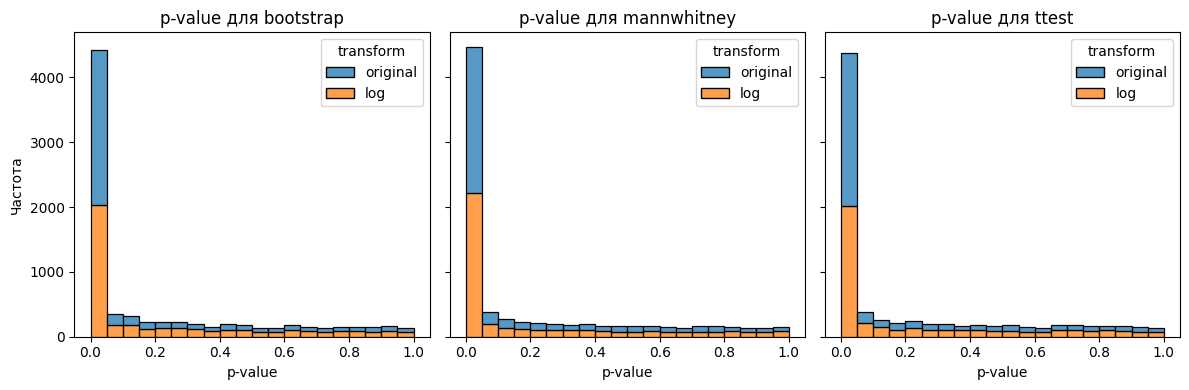

In [ ]:
%matplotlib inline
test_types = iteration_results_df['test_type'].unique()
fig, axes = plt.subplots(1, len(test_types), figsize=(12,4), sharey=True)

for ax, t in zip(axes, test_types):
    subset = iteration_results_df[iteration_results_df['test_type'] == t]
    sns.histplot(data=subset, x='p_value', hue='transform', multiple='stack', bins=20, ax=ax)
    ax.set_title(f"p-value для {t}")
    ax.set_xlabel("p-value")
    if ax == axes[0]:
        ax.set_ylabel("Частота")
    else:
        ax.set_ylabel("")
plt.tight_layout()

# исходя из графиков видны огромные пики в p-value = 0, что говорит о том, что может эффект добавлений был слишком большим

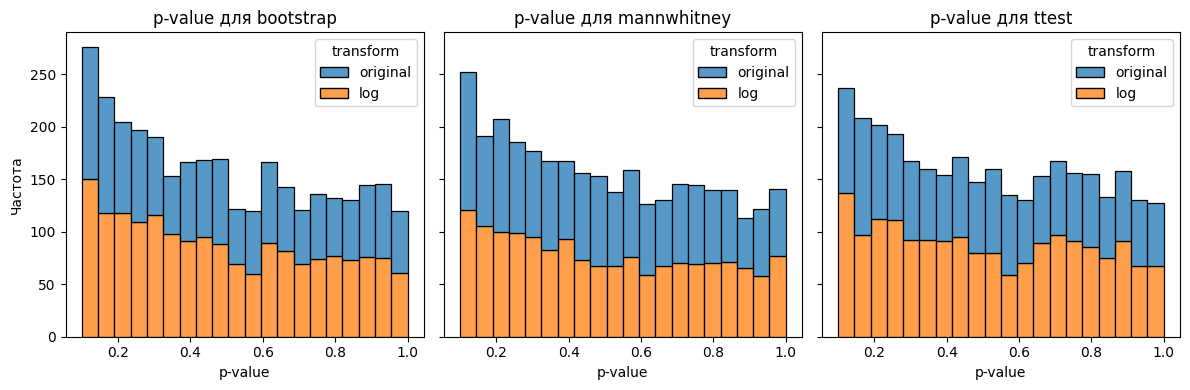

In [ ]:
test_types = iteration_results_df['test_type'].unique()
fig, axes = plt.subplots(1, len(test_types), figsize=(12,4), sharey=True)

for ax, t in zip(axes, test_types):
    subset = iteration_results_df[iteration_results_df['test_type'] == t]
    subset = subset[subset['p_value'] > 0.1] # отфильтруем p-value около 0
    sns.histplot(data=subset, x='p_value', hue='transform', multiple='stack', bins=20, ax=ax)
    ax.set_title(f"p-value для {t}")
    ax.set_xlabel("p-value")
    if ax == axes[0]:
        ax.set_ylabel("Частота")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.show()

видим, что логарифмирование абсолютно никак не отразилось на распределении p-values (графики в формате stack, не надо думать, что частота уменьшилась)

а вот на параметрах alpha и beta отразилось, давайте посмотрим результаты в таблице

In [138]:
summary_results_df.sort_values(
    by=['power', 'alpha'], ascending=[False, True] # сразу отсортируем по мощности и ошибке: нам нужна мощность как можно ближе к 1, а ошибка как можно ближе к 0
)

,test_type,transform,bias,alpha,power,beta,MDE
0,ttest,log,0.05,0.046,1.000,0.000,inf
1,ttest,original,0.05,0.050,1.000,0.000,inf
2,bootstrap,log,0.05,0.051,1.000,0.000,inf
3,mannwhitney,log,0.05,0.055,1.000,0.000,inf
4,mannwhitney,original,0.05,0.057,1.000,0.000,inf
5,bootstrap,original,0.05,0.060,1.000,0.000,inf
6,bootstrap,original,0.03,0.060,0.996,0.004,1.508385
7,ttest,original,0.03,0.050,0.994,0.006,1.488167
8,mannwhitney,log,0.03,0.055,0.948,0.052,0.202869
9,mannwhitney,original,0.03,0.057,0.948,0.052,1.174357


## Разбор пар критерий-метрика

1. **Исключение аномальных результатов**: Для bias = 5% результаты с MDE = `inf` (например, t-test, bootstrap, mannwhitney) сразу отбрасываются. Это означает, что мощность «взорвалась», и результаты непригодны для интерпретации.

2. **Bootstrap (original)**:
   - **bias = 3%**:
     - MDE = 1.508385
     - Power = 0.996 при alpha = 0.060
     - Высокая мощность, но alpha превышает порог 0.05, а MDE заметно выше, чем у других методов.
   - **bias = 1%**:
     - MDE = 0.484970
     - Power = 0.336 при alpha = 0.060
     - Низкая мощность, делает вариант непрактичным, несмотря на снижение MDE.

3. **Bootstrap (log)**:
   - **bias = 3%**:
     - MDE = 0.166752
     - Power = 0.832 при alpha = 0.051
     - Сильное снижение MDE за счет логарифмирования. При этом мощность остается на уровне 83.2%, что делает этот вариант одним из лучших.
   - **bias = 1%**:
     - MDE = 0.050878
     - Power = 0.144 при alpha = 0.051
     - Минимальный MDE, но мощность слишком низкая, что делает результат малопригодным.

4. **Mann-Whitney (original)**:
   - **bias = 3%**:
     - MDE = 1.174357
     - Power = 0.948 при alpha = 0.057
     - Высокая мощность, но MDE значительно выше, чем у логарифмированных методов.
   - **bias = 1%**:
     - MDE = 0.402587
     - Power = 0.244 при alpha = 0.057
     - Низкая мощность и более высокое MDE делают вариант слабым.

5. **Mann-Whitney (log)**:
   - **bias = 3%**:
     - MDE = 0.202869
     - Power = 0.948 при alpha = 0.055
     - Логарифмирование значительно уменьшает MDE, сохраняя мощность на высоком уровне (94.8%). Этот метод отлично подходит для поиска небольших эффектов.
   - **bias = 1%**:
     - MDE = 0.065628
     - Power = 0.220 при alpha = 0.055
     - Мощность выше, чем у других методов на bias = 1%, а MDE остается минимальным. Это делает Mann-Whitney (log) лидером для небольших эффектов.

6. **t-test (original)**:
   - **bias = 3%**:
     - MDE = 1.488167
     - Power = 0.994 при alpha = 0.050
     - Очень высокая мощность, но MDE гораздо выше, чем у других методов.
   - **bias = 1%**:
     - MDE = 0.499362
     - Power = 0.323 при alpha = 0.050
     - Слабая мощность и высокое MDE делают результат непрактичным.

7. **t-test (log)**:
   - **bias = 3%**:
     - MDE = 0.169265
     - Power = 0.832 при alpha = 0.046
     - Хороший компромисс: низкое alpha, допустимый MDE и мощность.
   - **bias = 1%**:
     - MDE = 0.051855
     - Power = 0.138 при alpha = 0.046
     - Мощность слишком низкая, что делает результат слабым, несмотря на минимальное MDE.

### Рекомендация
- **Лучший баланс**: Mann-Whitney (log) при bias = 3%. Этот метод сочетает высокий уровень мощности (94.8%), низкое MDE (0.202869) и умеренное alpha (0.055). Он подходит для большинства сценариев, где мы ожидаем прибавку в 3%.
- **Для минимального MDE при 1% bias**: Mann-Whitney (log) при bias = 1%. Лидер по MDE (0.065628) в этом сегменте и относительно высокой мощности (22.0%) на таком малом эффекте. Его стоит выбрать, если нам критично важно минимизировать MDE.
- **Для высокой мощности при 3% bias**: Bootstrap (original) при bias = 3%. Самый большой MDE (1.508385) и мощность (99.6%) делают его самым мощным тестом, однако при условии, что ожидается высокий MDE.


## Итоговый выбор
**Mann-Whitney + log (логарифмированная метрика длительности просмотров)** — оптимальный вариант для стабильных и чувствительных результатов. Имеет маленький MDE за счет логарифмирования, отличную мощность в практически 95% и вполне допустимую вероятность ошибки первого рода в 5.5%. На bias=0.01 все подходы ведут себя плохо, поэтому эта пара рассматривается при ожидаемом эффекте в 3%.

# A/B тест

In [196]:
two_week_nulled = two_week.copy()
# зануляем total_dur для пользователей с total_dur < 500
two_week_nulled.loc[two_week['total_dur'] < 500, 'total_dur'] = 0

two_week_nulled = groups_splitter(two_week_nulled, columns=['user_id', 'total_dur', 'group'], user_salt='kiontestmodel20210805')
two_week_nulled['group'].value_counts()
# ну не совсем и равные группы, но будет считать что норм

group
A    138420
B    137196
Name: count, dtype: int64

In [197]:
# добавляем топ 10% пользователям по продолжительности для группы B
two_week_nulled.loc[
        (two_week_nulled['total_dur'] >= two_week_nulled['total_dur'].quantile(0.90)) &\
        (two_week_nulled['group'] == 'B'),
    'total_dur'
] *= (1 + 0.025)

# выбросы в 3std уже выкинуты, теперь надо прологарифмировать
two_week_nulled['metric'] = np.log2(two_week_nulled['total_dur'])

mask_a = (two_week_nulled['group'].values == 'A')
mask_b = (two_week_nulled['group'].values == 'B')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vec_a = torch.tensor(two_week_nulled['metric'].values[mask_a].astype(np.float32), device=device)
vec_b = torch.tensor(two_week_nulled['metric'].values[mask_b].astype(np.float32), device=device)

# вызываем тест манна-уитни, как и определились выше
diff_means, p, res = test_mannwhitney(vec_a, vec_b)
print(f"Нулевая гипотеза{' не' if not res else ''} отвергается, p-value: {p:.6f}")

Нулевая гипотеза не отвергается, p-value: 0.084054


```
Нулевая гипотеза не отвергнута, так как p-value составляет 0.084, что выше порогового значения 0.05. Это указывает на отсутствие статистически значимой разницы между группами.  

Возможно, эффект был недостаточно выраженным, так как изменения наблюдались только у 10% пользователей, и эти изменения были небольшими по величине. Кроме того, близость p-value к 0.05 может указывать на то, что эффекта немного не хватило, либо из-за его слабости, либо из-за его ограниченного влияния на пользователей.

Выбранная комбинация метрики и данных не позволила обнаружить значимого различия между группами, что могло быть связано с низкой мощностью теста или недостаточной выборкой.
```